In [2]:
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import torch
from transformers import AutoTokenizer
import torch
import torch.nn.functional as F
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler
from transformers import CLIPTextModel, AutoTokenizer
from peft import LoraConfig, get_peft_model
import os
from tqdm import tqdm

In [3]:
class SketchToAnimeSDDataset(Dataset):
    def __init__(self, sketch_dir, anime_dir, image_size=512, tokenizer=None):
        self.sketch_dir = sketch_dir
        self.anime_dir = anime_dir
        
        # Asegurarse de que los archivos estén alineados
        self.sketches = sorted([f for f in os.listdir(sketch_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
        self.animes = sorted([f for f in os.listdir(anime_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
        
        # Verificar que tengamos el mismo número de archivos
        assert len(self.sketches) == len(self.animes), "Número diferente de sketches y animes"
        
        self.image_size = image_size
        self.tokenizer = tokenizer or AutoTokenizer.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="tokenizer")
        
        # Transformaciones para las imágenes
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
        
        # Prompt fijo para entrenamiento
        self.prompt = "anime style, high quality, detailed"

    def __len__(self):
        return len(self.sketches)

    def __getitem__(self, idx):
        sketch_path = os.path.join(self.sketch_dir, self.sketches[idx])
        anime_path = os.path.join(self.anime_dir, self.animes[idx])

        # Cargar imágenes
        sketch = Image.open(sketch_path).convert("RGB")
        anime = Image.open(anime_path).convert("RGB")
        
        # Aplicar transformaciones
        sketch_tensor = self.transform(sketch)
        anime_tensor = self.transform(anime)
        
        # Tokenizar el prompt
        text_inputs = self.tokenizer(
            self.prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        
        return {
            "sketch": sketch_tensor,
            "anime": anime_tensor,
            "input_ids": text_inputs.input_ids[0],
            "prompt": self.prompt
        }

In [4]:
model_id = "runwayml/stable-diffusion-v1-5"
batch_size = 2  # Reducido por la memoria de 6GB
image_size = 512
num_epochs = 3
learning_rate = 1e-4

# Cargar tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id, subfolder="tokenizer")

# Cargar modelos
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")
scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
dataset = SketchToAnimeSDDataset(
	sketch_dir=r"D:\Ciencias\Drawnime\data\train\sketches",
	anime_dir=r"D:\Ciencias\Drawnime\data\train\faces",
	image_size=512,
	tokenizer=tokenizer
)
train_loader = DataLoader(dataset, batch_size=1, shuffle=True)

# Usar solo 500 imágenes como mencionaste
train_dataset = torch.utils.data.Subset(dataset, range(min(100, len(dataset))))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

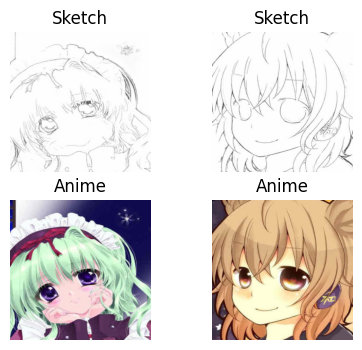

In [6]:
from matplotlib import pyplot as plt


batch = next(iter(train_loader))
plt.figure(figsize=(10, 4))
for i in range(2):
    plt.subplot(2, 4, i+1)
    plt.imshow(((batch["sketch"][i].permute(1, 2, 0) * 0.5) + 0.5))
    plt.title("Sketch")
    plt.axis("off")
    plt.subplot(2, 4, i+5)
    plt.imshow(((batch["anime"][i].permute(1, 2, 0) * 0.5) + 0.5))
    plt.title("Anime")
    plt.axis("off")
plt.show()

In [7]:
import torch
import torch.nn.functional as F
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler
from transformers import CLIPTextModel, AutoTokenizer
from peft import LoraConfig, get_peft_model
import os
from tqdm import tqdm

def setup_lora(unet, text_encoder):
    # Configuración LoRA para UNet
    lora_config = LoraConfig(
        r=16,  # Rank
        lora_alpha=32,
        target_modules=["to_k", "to_q", "to_v", "to_out.0", "proj_in", "proj_out"],
        lora_dropout=0.1,
    )
    
    unet = get_peft_model(unet, lora_config)
    unet.print_trainable_parameters()
    
    return unet, text_encoder

def train_sketch_to_anime(unet, vae, text_encoder, train_loader, scheduler):
    # Mover a GPU
    vae.to(device)
    unet.to(device)
    text_encoder.to(device)
    
    # Congelar VAE y text encoder
    vae.requires_grad_(False)
    text_encoder.requires_grad_(False)
    
    # Aplicar LoRA solo a UNet
    unet, text_encoder = setup_lora(unet, text_encoder)
    
    # Optimizador solo para parámetros entrenables
    optimizer = torch.optim.AdamW(unet.parameters(), lr=learning_rate)

    unet.train()
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for batch in progress_bar:
            # Mover datos a GPU
            sketches = batch["sketch"].to(device)
            animes = batch["anime"].to(device)
            input_ids = batch["input_ids"].to(device)
            
            # Codificar imágenes con VAE (usamos los animes como target)
            with torch.no_grad():
                # Codificar imágenes anime a latents
                anime_latents = vae.encode(animes).latent_dist.sample()
                anime_latents = anime_latents * vae.config.scaling_factor
                
                # Codificar sketches para condición
                sketch_latents = vae.encode(sketches).latent_dist.sample()
                sketch_latents = sketch_latents * vae.config.scaling_factor
            
            # Sample noise
            noise = torch.randn_like(anime_latents)
            timesteps = torch.randint(0, scheduler.num_train_timesteps, (anime_latents.shape[0],), device=device)
            
            # Add noise to latents
            noisy_latents = scheduler.add_noise(anime_latents, noise, timesteps)
            
            # Codificar texto
            with torch.no_grad():
                encoder_hidden_states = text_encoder(input_ids)[0]
            
            # Predicción del noise - CORREGIDO
            noise_pred = unet(
                noisy_latents, 
                timesteps, 
                encoder_hidden_states,
                added_cond_kwargs={"image_embeds": sketch_latents}
            ).sample
            
            # Loss - comparar con el noise original
            loss = F.mse_loss(noise_pred, noise)
            
            # Backward
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(unet.parameters(), 1.0)
            optimizer.step()
            
            epoch_loss += loss.item()
            progress_bar.set_postfix({"loss": loss.item()})
        
        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")

        # Guardar checkpoint cada 10 épocas
        if (epoch + 1) % 10 == 0:
            save_path = f"./lora_checkpoint_epoch_{epoch+1}"
            os.makedirs(save_path, exist_ok=True)
            unet.save_pretrained(save_path)
            print(f"Checkpoint guardado en {save_path}")
    
    # Guardar modelo final
    unet.save_pretrained("./sketch_to_anime_lora_final")
    print("Entrenamiento completado!")


In [ ]:
# Run training function
train_sketch_to_anime(unet, vae, text_encoder, train_loader, scheduler)

trainable params: 3,987,456 || all params: 863,508,420 || trainable%: 0.4618


Epoch 1/3:   0%|          | 0/50 [00:00<?, ?it/s]d:\Programs\Python\3.12.7\Lib\site-packages\diffusers\configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
Epoch 1/3: 100%|██████████| 50/50 [27:11<00:00, 32.63s/it, loss=0.108]  


Epoch 1, Average Loss: 0.1557


Epoch 2/3: 100%|██████████| 50/50 [27:00<00:00, 32.40s/it, loss=0.105] 


Epoch 2, Average Loss: 0.1413


Epoch 3/3: 100%|██████████| 50/50 [27:00<00:00, 32.42s/it, loss=0.0812]

Epoch 3, Average Loss: 0.1273
Entrenamiento completado!


: 

In [8]:
from diffusers import StableDiffusionPipeline, ControlNetModel
import torch
from peft import PeftModel

def load_lora_model(base_model_id, lora_path):
    pipe = StableDiffusionPipeline.from_pretrained(
        base_model_id,
        torch_dtype=torch.float16,
        safety_checker=None,
        requires_safety_checker=False
    )
    
    pipe.unet = PeftModel.from_pretrained(pipe.unet, lora_path)
    pipe = pipe.to("cuda")
    return pipe

def generate_anime_from_sketch(sketch_path, pipe):
    # Cargar y preprocesar sketch
    from PIL import Image
    from torchvision import transforms
    
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    
    sketch = Image.open(sketch_path).convert("RGB")
    sketch_tensor = transform(sketch).unsqueeze(0).half().to("cuda")
    
    # Generar imagen
    with torch.no_grad():
        # Aquí necesitarías adaptar el pipeline para aceptar condition images
        # Esto es una simplificación - necesitarías modificar el pipeline
        result = pipe(
            prompt="anime style, high quality, detailed",
            num_inference_steps=20,
            guidance_scale=7.5,
            width=512,
            height=512
        ).images[0]
    
    return result

# Uso
pipe = load_lora_model("runwayml/stable-diffusion-v1-5", "./sketch_to_anime_lora_final")
result = generate_anime_from_sketch(r"D:\Ciencias\Drawnime\data\val\sketches\9251.jpg", pipe)
result.save("anime_resultado.png")

100%|██████████| 20/20 [00:03<00:00,  5.35it/s]


In [27]:
from diffusers import StableDiffusionImg2ImgPipeline
from PIL import Image
import torch

def setup_img2img_with_lora(base_model_id, lora_path):
    """Configurar pipeline img2img con LoRA"""
    
    pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
        base_model_id,
        torch_dtype=torch.float16,
        safety_checker=None,
    )
    
    # Cargar LoRA
    from peft import PeftModel
    pipe.unet = PeftModel.from_pretrained(pipe.unet, lora_path)
    
    pipe = pipe.to("cuda")
    return pipe

def generate_with_img2img(sketch_path, pipe, strength=0.7):
    """Generar usando img2img - el sketch como base"""
    
    # Cargar sketch
    init_image = Image.open(sketch_path).convert("RGB")
    init_image = init_image.resize((512, 512))
    
    # Generar
    result = pipe(
        prompt="anime style, high quality, detailed, hair with vibrant colors, masterpiece",
        image=init_image,
        strength=strength,  # Controla cuánto modificar (0.6-0.8 funciona bien)
        num_inference_steps=20,
        guidance_scale=9,
    ).images[0]
    
    return result

In [ ]:

pipe = setup_img2img_with_lora("runwayml/stable-diffusion-v1-5", "./sketch_to_anime_lora_final")
result = generate_with_img2img(r"D:\Ciencias\Drawnime\data\val\sketches\9251.jpg", pipe, strength=0.75)
result.save("anime_resultado_image2image.png")

Loading pipeline components...: 100%|██████████| 6/6 [00:04<00:00,  1.34it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|██████████| 15/15 [00:02<00:00,  5.75it/s]


In [37]:
result = generate_with_img2img(r"D:\Downloads\test5.jpg", pipe, strength=0.6)
result.save("anime_resultado_image2image.png")

100%|██████████| 12/12 [00:02<00:00,  5.40it/s]
